# Nz CAS Design Example
#### Example 4.5-2 3rd edition

In [1]:
import sys
sys.path.append('../')
from params_f16 import F16Params, Controls
from lin_f16 import get_lin_f16 as linearize
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import control_tools as tools

#### Constants

In [2]:
ALPHA_IDX = 1   # body-axis angle of attack
THETA_IDX = 2   # body-axis pitch attitude
Q_IDX = 3   # body-axis pitch rate
NZ_G_IDX = 6 # load factor in z direction (g's)
GAMMA_IDX = 7 # flight path angle (deg)

THROTTLE_IDX = 0 # throttle control input
ELEVATOR_IDX = 1 # elevator control input

#### Set Trim Condition

In [3]:
params = F16Params()
params.alt_ft = 0.0
params.VT_ftps = 502.0
params.xcg = 0.35
controls = Controls()

#### Linearize About Trim Condition

In [4]:
lon_sys, _ = linearize(controls, params)

Trim results:
Throttle (0-1): 0.26
Elevator (deg): -0.76
Alpha (deg): 2.12
Aileron (deg): 0.00
Rudder (deg): -0.00
Beta (deg): -0.00


#### Extract plant from full longitudinal system

In [5]:
ap = lon_sys.A
bp = lon_sys.B[:,[ELEVATOR_IDX]]
cp = lon_sys.C[[Q_IDX, NZ_G_IDX]]
dp = lon_sys.D[[Q_IDX, NZ_G_IDX]] [:,[ELEVATOR_IDX]]
sysp = ct.ss(ap, bp, cp, dp)


#### Cascade Actuator

In [6]:
Ta = 20.2
sysa = ct.ss(-Ta, Ta, -1, 0) # actuator dynamics (include sign change)
sys1 = ct.series(sysa, sysp) # series connection

#### Close q loop with reasonable guess

In [7]:
acl = sys1.A - np.dot(np.dot(sys1.B,np.array([[0.4, 0]])), sys1.C)
sys2 = ct.ss(acl, sys1.B, sys1.C[[1]], sys1.D[[1]]) # extract nz loop

zeros = ct.zero(sys2)
poles = ct.pole(sys2)

wn_zeros, zeta_zeros = tools.wn_zeta(zeros)
wn_poles, zeta_poles = tools.wn_zeta(poles)

print("Zeros: wn =", wn_zeros, "\nzeta =", zeta_zeros)
print("Poles: wn =", wn_poles, "\nzeta =", zeta_poles)
print(ct.ss2tf(sys2))

Zeros: wn = [7.61552475e+00 7.61552475e+00 5.73185270e-03 8.65282663e-04
 8.65282663e-04 1.00000000e+00] 
zeta = [0.41657041 0.41657041 1.         0.57018029 0.57018029 1.        ]
Poles: wn = [1.37777121e+01 7.65836677e+00 8.53443836e-01 5.05514978e-02
 3.35456975e-02 1.42939277e-03 1.00000000e+00] 
zeta = [ 1.  1.  1.  1. -1.  1.  1.]

0.9803 s^6 + 7.206 s^5 + 63.12 s^4 + 57.28 s^3 + 0.3824 s^2 + 0.0003644 s + 2.44e-07
-------------------------------------------------------------------------------------
s^7 + 23.31 s^6 + 146.5 s^5 + 216.5 s^4 + 93.75 s^3 + 1.302 s^2 - 0.151 s - 0.0002183



#### Cascade Nz compensator

In [8]:
z_Nz = 0.9
sysc = ct.ss([[0]], [[z_Nz]], [[z_Nz]], [[1]]) # PI compensator
sys3 = ct.series(sysc, sys2)

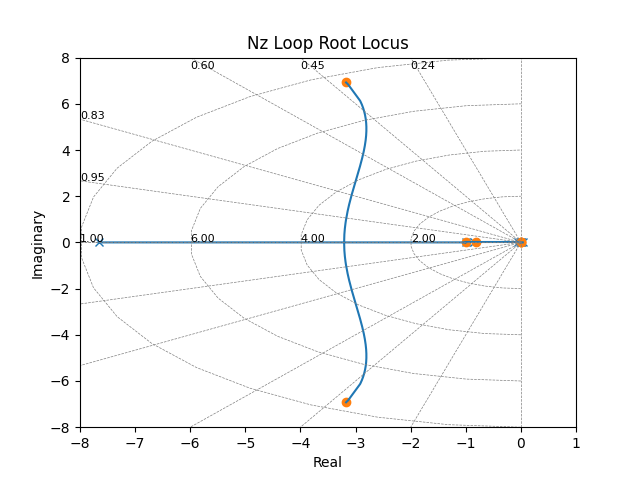

In [9]:
%matplotlib widget
ct.root_locus(sys3, grid=True, xlim=[-8, 1], ylim=[-8, 8])
plt.title('Nz Loop Root Locus')
plt.show()

#### Choose Kp = 5

In [10]:
acl = sys3.A - np.dot(np.dot(sys3.B,np.array([[5]])), sys3.C)
sys_cl = ct.ss(acl, sys3.B, sys3.C, sys3.D) # closed loop system

zeros = ct.zero(sys_cl)
poles = ct.pole(sys_cl)

wn_zeros, zeta_zeros = tools.wn_zeta(zeros)
wn_poles, zeta_poles = tools.wn_zeta(poles)

print("Closed Loop Zeros:", zeros)
print("Closed Loop Poles:", poles)
print(ct.ss2tf(sys_cl))
print("DC Gain =", ct.dcgain(sys_cl))

Closed Loop Zeros: [-8.10000000e-01+0.00000000e+00j -3.17240227e+00+6.92329986e+00j
 -3.17240227e+00-6.92329986e+00j -5.73185269e-03+0.00000000e+00j
 -4.93367125e-04+7.10846335e-04j -4.93367125e-04-7.10846335e-04j
 -1.00000000e+00+0.00000000e+00j]
Closed Loop Poles: [-2.03121405e+01+0.00000000e+00j -3.04838062e+00+2.24643526e+00j
 -3.04838062e+00-2.24643526e+00j -7.94352896e-01+0.00000000e+00j
 -5.13892736e-03+0.00000000e+00j -4.47325607e-04+7.94346463e-04j
 -4.47325607e-04-7.94346463e-04j -1.00000000e+00+0.00000000e+00j]

   0.9803 s^7 + 8 s^6 + 68.96 s^5 + 108.4 s^4 + 46.78 s^3 + 0.3101 s^2 + 0.0002954 s + 1.976e-07
----------------------------------------------------------------------------------------------------
s^8 + 28.21 s^7 + 186.5 s^6 + 561.3 s^5 + 635.8 s^4 + 235.2 s^3 + 1.399 s^2 + 0.001259 s + 9.881e-07

DC Gain = 0.1999999999999318


#### Look at step response

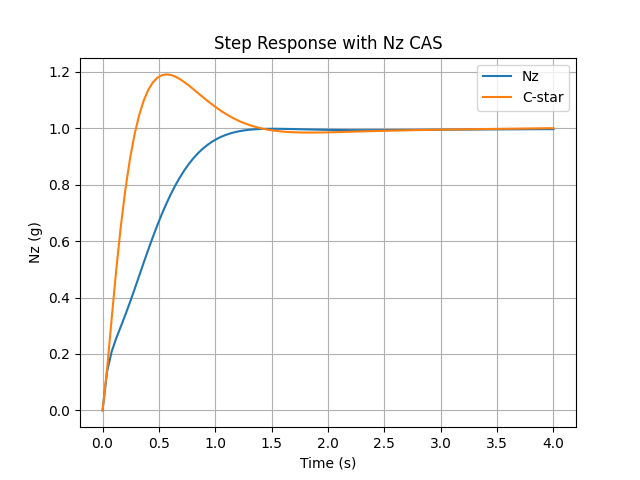

In [11]:
sys_c_star = ct.ss(acl, sys3.B, sys3.C + np.array([[0,0,0,0,0,12.4,0,0]]), sys3.D) # closed loop system
sys_Nz = sys_cl / ct.dcgain(sys_cl) # normalized to 1
t = np.linspace(0, 4, 100)
t, y = ct.step_response(sys_Nz, t)
_, y_c_star = ct.step_response(sys_c_star, t)
plt.figure()
plt.plot(t, y.T)
plt.plot(t, y_c_star / y_c_star[99]) # normalized
plt.xlabel('Time (s)')
plt.ylabel('Nz (g)')
plt.title('Step Response with Nz CAS')
plt.legend(['Nz', 'C-star'])
plt.grid()
plt.show()